This is a multi-class classification contest on Kaggle.
Problem statement and Datasets can be found here: https://www.kaggle.com/c/cassava-leaf-disease-classification

For this task I have done exploratory data analysis and have used transfer learning with a pretrained model EfficientNetB3.

In [178]:
import numpy as np
import pandas as pd
import os,json
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import EfficientNetB3, EfficientNetB4
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, Dense, Flatten, Dropout
from tensorflow.keras.layers import  GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.losses import Loss

#for graphs and images
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

In [179]:
dir_path = '/kaggle/input/cassava-leaf-disease-classification/'

In [180]:
train_df = pd.read_csv(dir_path + 'train.csv')
print('train_df = ', train_df.shape)
train_df.info()

train_df =  (21397, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [181]:
df = train_df.copy()

with open(dir_path + "label_num_to_disease_map.json") as f:
    classes = json.load(f)
    
df['class_name'] = df['label'].map(lambda x: classes[str(x)] )
df.head()   

image_id  label                           class_name
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

label  class_name                         
0      Cassava Bacterial Blight (CBB)          1087
1      Cassava Brown Streak Disease (CBSD)     2189
2      Cassava Green Mottle (CGM)              2386
3      Cassava Mosaic Disease (CMD)           13158
4      Healthy                                 2577
Name: class_name, dtype: int64


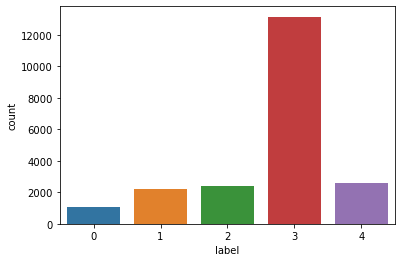

In [182]:
ax = sns.countplot(data=df, x='label')
label_count = df.groupby(['label','class_name'])['class_name'].count()
print(label_count)

#  '0': 'Cassava Bacterial Blight (CBB)
#  '1': 'Cassava Brown Streak Disease (CBSD)
#  '2': 'Cassava Green Mottle (CGM)
#  '3': 'Cassava Mosaic Disease (CMD)
#  '4': 'Healthy

Let's visualize a few pictures from each class.

In [183]:
train_images = dir_path + 'train_images/' 

def show_images(class_label):
    ndf = df[df.label==class_label].reset_index(drop=True)
    plt.figure(figsize=(14,14))
    for i in range(10):
        img = train_images + ndf.loc[i,'image_id']
        img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
        plt.subplot(5,5,i+1)
        plt.imshow(img)
        plt.suptitle(ndf.loc[i,'class_name'], y=1.04, fontsize=18)
        plt.axis("off")
    plt.tight_layout()

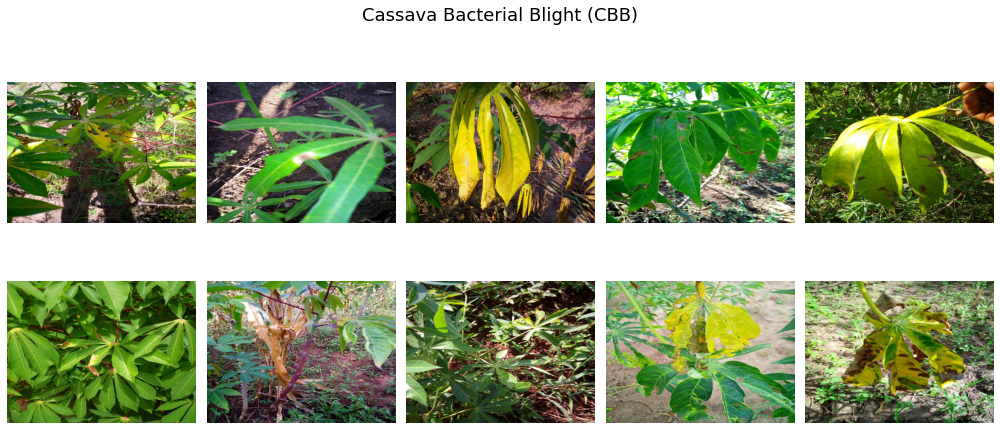

In [184]:
show_images(0)

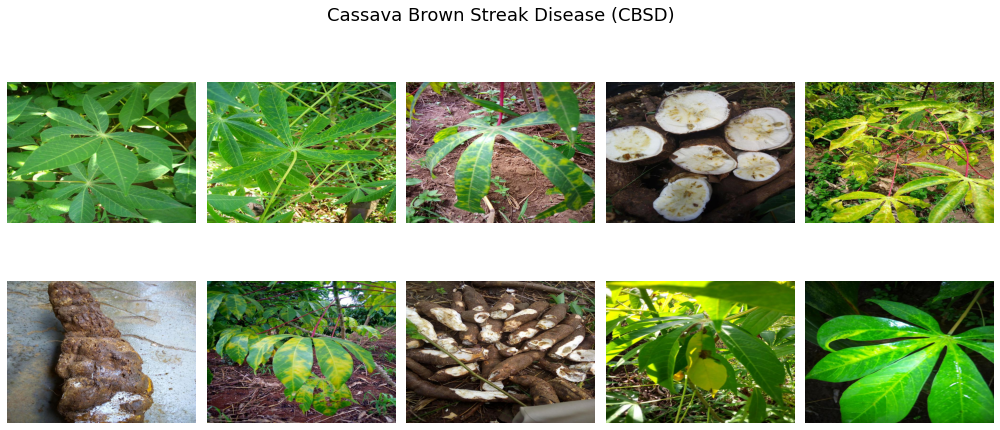

In [185]:
show_images(1)

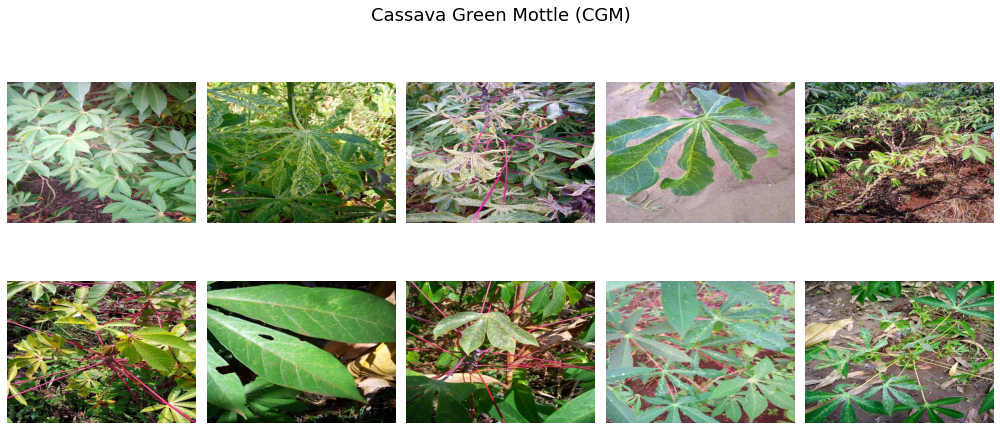

In [186]:
show_images(2)

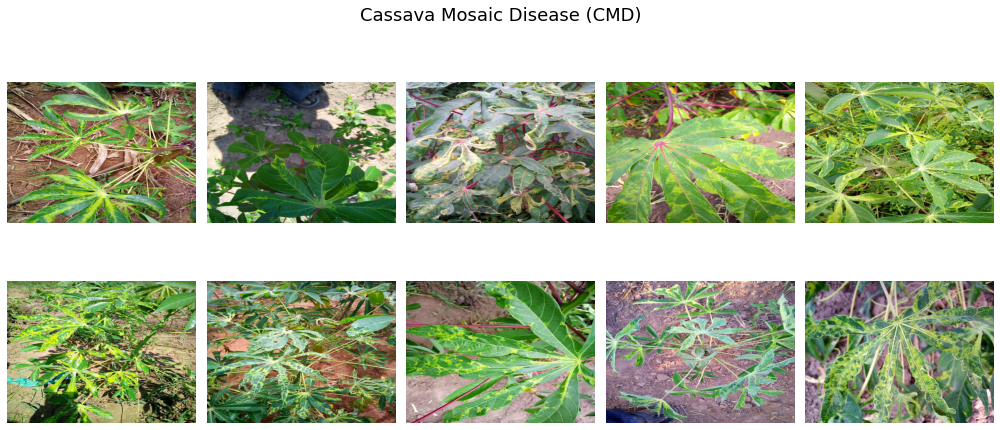

In [187]:
show_images(3)

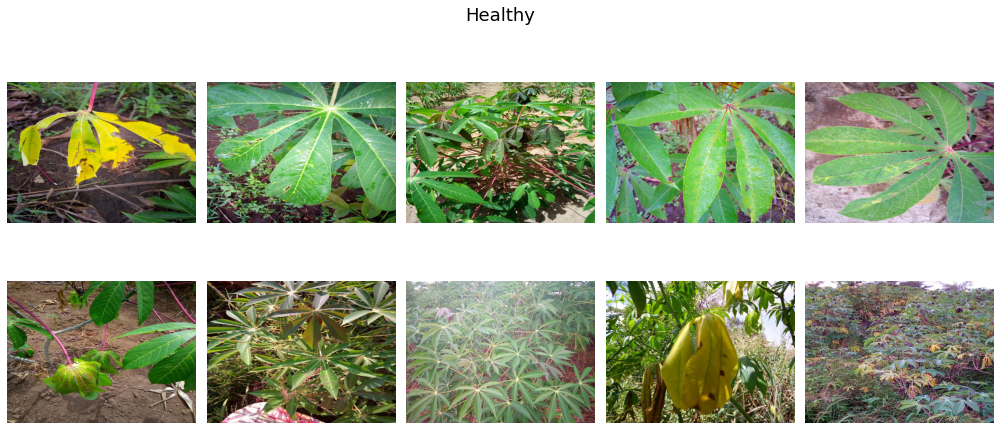

In [188]:
show_images(4)

In [189]:
image = train_images + df.loc[0,'image_id']
print('image dimensions = ',np.shape(cv2.imread(image)))

image dimensions =  (600, 800, 3)


***It seems that some images in some classes look very different from the rest of the class. This might be an indication of outliers. So we should detect outliers based on the statistics of images in each disease class.***

***First I create a dictionary which includes all classes and the statistics of each image whithin that class.***

In [190]:
image_stats = {'Cassava Bacterial Blight (CBB)':[],
                          'Cassava Mosaic Disease (CMD)':[],
                          'Cassava Brown Streak Disease (CBSD)':[],
                          'Cassava Green Mottle (CGM)':[],
                          'Healthy' : []}

for class_name in tqdm(df.class_name.unique()):
    new_df = df[df.class_name == class_name]
    for idx in tqdm(new_df.index):
        img = train_images + new_df.loc[idx,'image_id']
        # Normalize the image
        img = cv2.imread(img)
        norm_img = cv2.normalize(img, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mean, std = np.mean(norm_img), np.std(norm_img)
        # Store mean and std of the image and its dataframe index. 
        image_stats[class_name].append([mean, std, idx])

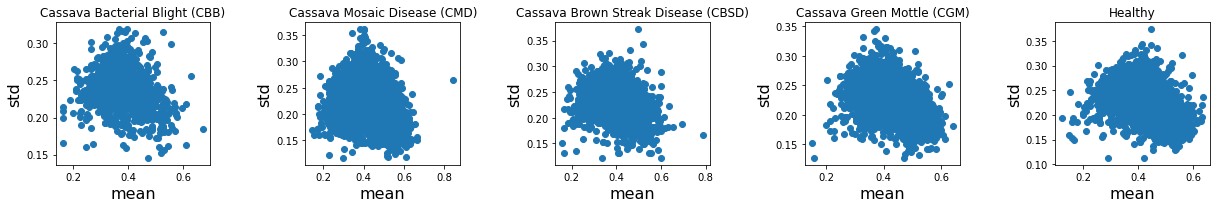

In [191]:
# Scatter plots
fig, ax = plt.subplots(1,5,figsize=(17,3))
for i, class_name in enumerate(df.class_name.unique()):
    image_stats[class_name] = np.asarray(image_stats[class_name])
    ax[i].scatter(image_stats[class_name][:,0], image_stats[class_name][:,1])
    ax[i].set_title(class_name)
    ax[i].set_xlabel('mean',fontsize=16)
    ax[i].set_ylabel('std',fontsize=16)
    plt.tight_layout()

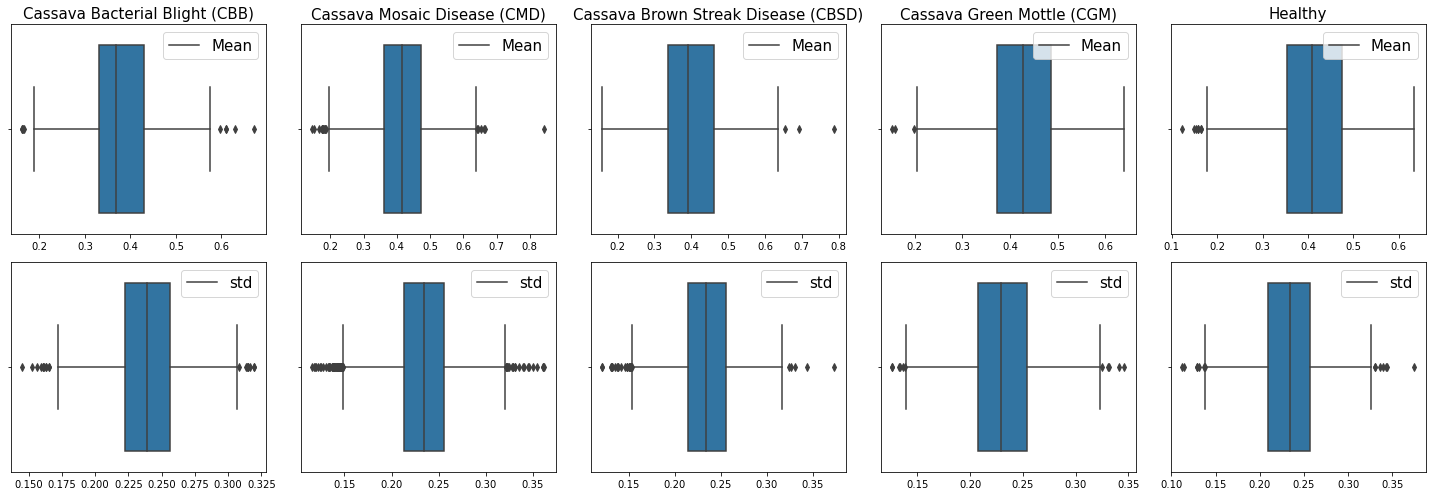

In [192]:
# box plots
fig, ax = plt.subplots(2,5,figsize=(20,7))
for i, class_name in enumerate(df.class_name.unique()):
    image_stats[class_name] = np.asarray(image_stats[class_name])
    sns.boxplot(x=image_stats[class_name][:,0], ax=ax[0,i])
    sns.boxplot(x=image_stats[class_name][:,1], ax=ax[1,i])
    ax[0,i].set_title(class_name, fontsize=15)
    ax[0,i].legend(['Mean'], fontsize=15)
    ax[1,i].legend(['std'], fontsize=15)
    plt.tight_layout()

***From the scatter plots and box plots we can see the presence of outliers for both mean and standard deviation. We can remove them with IQR method.***

In [193]:
image_stats_new = image_stats.copy()
df_new = df.copy()
all_outliers = []

def IQR(X):
    q1, q3 = np.percentile(X,[25,75])
    iqr = q3 - q1
    lower_bound  = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)
    out_index = np.where((X > upper_bound) | (X < lower_bound))[0]
    return out_index

# Find the outliers within each class and remove them
for class_name in tqdm(df.class_name.unique()):
    mean_list = image_stats[class_name][:,0] 
    std_list = image_stats[class_name][:,1]
    outlier_indexes = np.append(IQR(mean_list), IQR(std_list))
    for idx in sorted(outlier_indexes, reverse=True):
        # Outlier indexes in dataframe
        df_index_outlier = image_stats_new[class_name][idx,2]
        all_outliers.append(df_index_outlier)
        # Remove outliers from dataframe
        df_new.drop(df_index_outlier, inplace=True)
        # Remove ouliers from image_stats
        image_stats_new[class_name] = np.delete(image_stats_new[class_name], obj=idx, axis=0)

***Now let's see how the box plots look like after removing the outilers based on IQR method.***

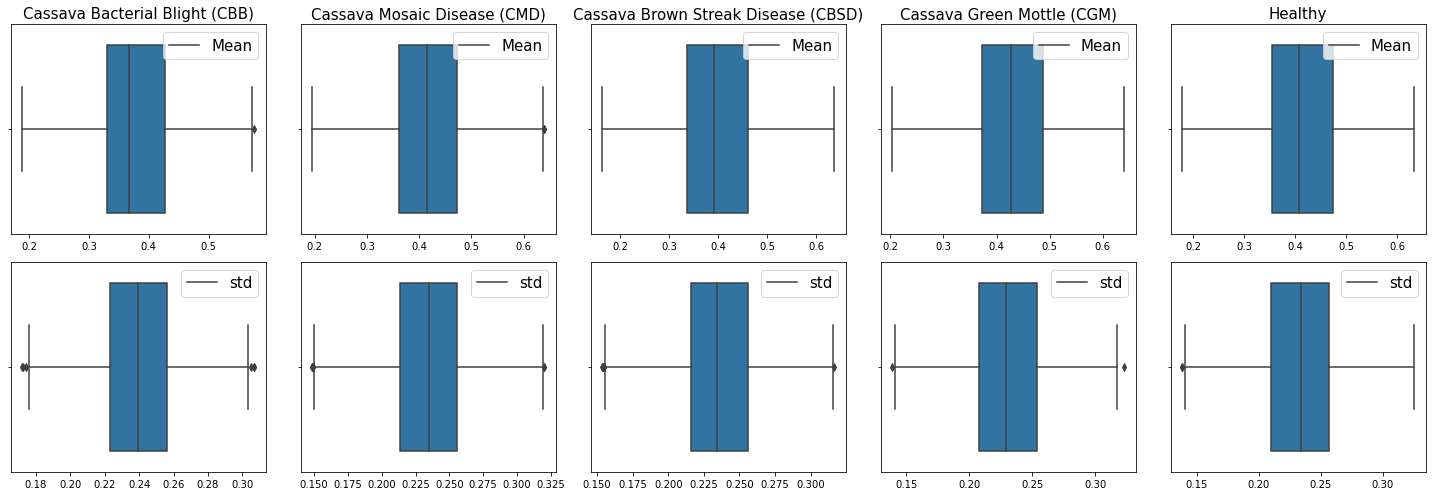

In [194]:
# box plots
fig, ax = plt.subplots(2,5,figsize=(20,7))
for i, class_name in enumerate(df.class_name.unique()):
    image_stats_new[class_name] = np.asarray(image_stats_new[class_name])
    sns.boxplot(x=image_stats_new[class_name][:,0], ax=ax[0,i])
    sns.boxplot(x=image_stats_new[class_name][:,1], ax=ax[1,i])
    ax[0,i].set_title(class_name, fontsize=15)
    ax[0,i].legend(['Mean'], fontsize=15)
    ax[1,i].legend(['std'], fontsize=15)
    plt.tight_layout()

In [195]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21200 entries, 0 to 21396
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    21200 non-null  object
 1   label       21200 non-null  int64 
 2   class_name  21200 non-null  object
dtypes: int64(1), object(2)
memory usage: 662.5+ KB


***Let's visualize some of the removed ouliers.***

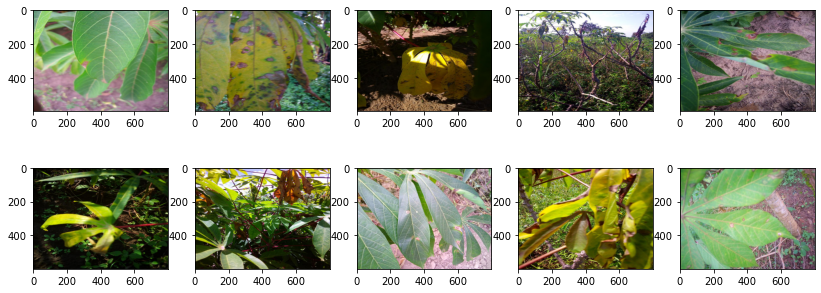

In [196]:
plt.figure(figsize=(14,14))
for i, idx in enumerate(all_outliers[10:20]):
    outlier_img = train_images + df.loc[idx,'image_id']
    outlier_img = cv2.cvtColor(cv2.imread(outlier_img), cv2.COLOR_BGR2RGB)
    plt.subplot(5,5,i+1)
    plt.imshow(outlier_img)
plt.show()

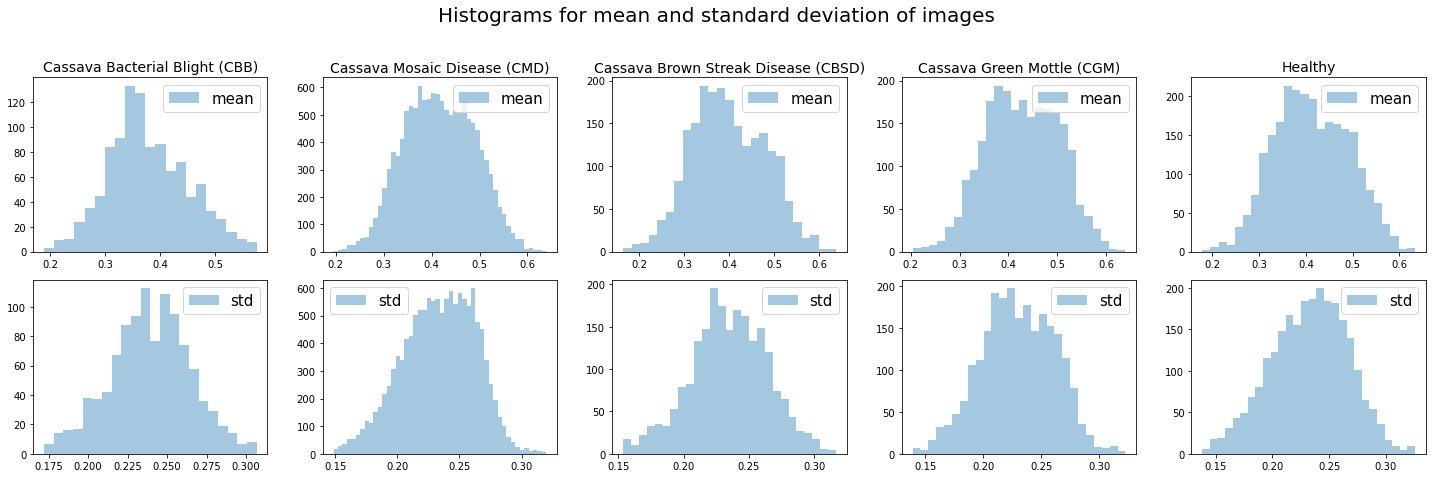

In [197]:
fig, ax = plt.subplots(2,5, figsize=(20,6))
for i, class_name in enumerate(image_stats):
    ax1 = sns.distplot(image_stats_new[class_name][:,0], kde=False, ax=ax[0,i], label='mean')
    ax2 = sns.distplot(image_stats_new[class_name][:,1], kde=False, ax=ax[1,i], label='std')
    ax[0,i].set_title(class_name, fontsize=14)
    ax[0,i].legend(fontsize=15)
    ax[1,i].legend(fontsize=15)
    plt.suptitle('Histograms for mean and standard deviation of images', y=1.1, fontsize=20)
    plt.tight_layout()

***We can import and augment the data using ImageDataGenerator.***

In [198]:
df_new.pop('class_name')

0             Cassava Bacterial Blight (CBB)
1               Cassava Mosaic Disease (CMD)
2        Cassava Brown Streak Disease (CBSD)
3        Cassava Brown Streak Disease (CBSD)
4               Cassava Mosaic Disease (CMD)
                        ...                 
21392           Cassava Mosaic Disease (CMD)
21393           Cassava Mosaic Disease (CMD)
21394    Cassava Brown Streak Disease (CBSD)
21395                                Healthy
21396                                Healthy
Name: class_name, Length: 21200, dtype: object

In [227]:
df = df_new.copy()
df.label = df.label.astype('str')

BATCH_SIZE = 20  
SIZE = 300

train, validation = train_test_split(df, test_size = 0.1, random_state = 42)


datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

datagen_validation = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

train_generator = datagen_train.flow_from_dataframe(train,
                             directory = train_images,
                             target_size = (SIZE,SIZE),
                             x_col = 'image_id',
                             y_col = 'label',
                             color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             batch_size = BATCH_SIZE,
                             shuffle = True)

validation_generator = datagen_validation.flow_from_dataframe(validation,
                             directory = train_images,
                             target_size = (SIZE,SIZE),
                             x_col = 'image_id',
                             y_col = 'label',
                             color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             batch_size = BATCH_SIZE,
                             shuffle = True)


Found 19080 validated image filenames belonging to 5 classes.
Found 2120 validated image filenames belonging to 5 classes.


***In the next cell, I have shown 10 augmented images from one image.***

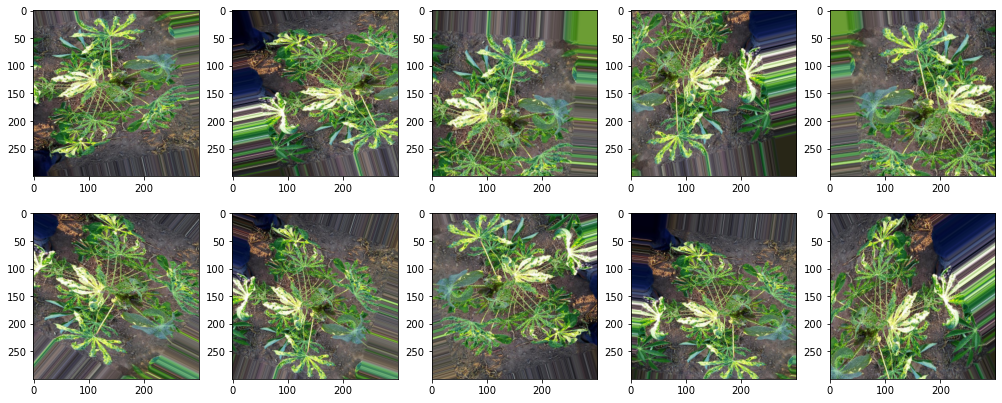

In [217]:
aug_images = [train_generator[0][0][0] for i in range(10)]
plt.figure(figsize=(14,14))
for i, img in enumerate(aug_images):
    plt.subplot(5,5,i+1)
    plt.imshow(img)
plt.tight_layout()
plt.show()

  ***I will use a pre-trained EfficientNetB4 for training.
The weights are the 'imagenet' weights which are trained for object classification. We use the already trained initial layers which detects lower-level features like edges and then we replace the top layers with our own dense layers to recognize higher level features and this is the reason we set the include_top parameter of the EfficientNet to False.***

***This is called Transfer Learning.***

In [229]:
class SimpleQuadraticDense(Layer):

    def __init__(self, units, activation):
        super().__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        a_init = tf.random_normal_initializer()
        self.a = tf.Variable(name='kernel', initial_value=a_init(shape=(input_shape[-1], self.units)),
                          trainable=True)
      
        b_init = tf.random_normal_initializer()
        self.b = tf.Variable(name='kernel', initial_value=b_init(shape=(input_shape[-1], self.units)),
                          trainable=True)
      
        c_init = tf.zeros_initializer()
        self.c = tf.Variable(name='bias', initial_value=c_init(shape=(self.units,)),
                           trainable=True)
      
    def call(self, inputs):
        return self.activation(tf.matmul(inputs**2, self.a) + tf.matmul(inputs, self.b) + self.c)
      

In [230]:
def build_model(num_classes):
    
    model = Sequential()
    EfficientNet = tf.keras.applications.EfficientNetB3(input_shape = (SIZE, SIZE, 3),
                                                        include_top = False,
                                                        weights = 'imagenet')
    model.add(EfficientNet)
    model.add(GlobalAveragePooling2D())
    #model.add(SimpleQuadraticDense(units = 128, activation='relu'))
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    optimizer = tf.keras.optimizers.Adam(lr=1e-3)
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["categorical_accuracy"])
    
    return model

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_59  (None, 1536)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 512)               786944    
_________________________________________________________________
dropout_62 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 5)                 2565      
Total params: 11,573,044
Trainable params: 11,485,741
Non-trainable params: 87,303
_________________________________________________________________


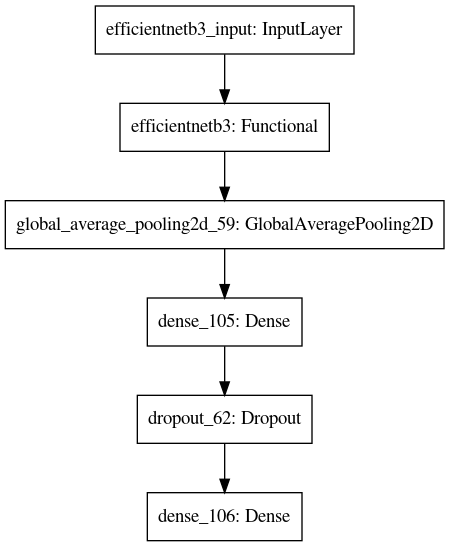

In [231]:
model = build_model(num_classes=5)
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
model = build_model(num_classes=5)
    
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                            patience = 4)

checkpoint = tf.keras.callbacks.ModelCheckpoint("EB4_weights.h5",
                                                save_weights_only = True,
                                                monitor = 'val_accuracy', 
                                                mode ='max')   
    

EPOCHS = 20 

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [callback, checkpoint],
    verbose=1)

model.save('MyModel.h5')
model.save('./MyModel_tf',save_format='tf')

Epoch 1/20
954/954 [==============================] - 764s 801ms/step - loss: 0.7019 - categorical_accuracy: 0.7556 - val_loss: 0.4910 - val_categorical_accuracy: 0.8415
Epoch 2/20
954/954 [==============================] - 746s 782ms/step - loss: 0.5394 - categorical_accuracy: 0.8169 - val_loss: 0.5148 - val_categorical_accuracy: 0.8406
Epoch 3/20
954/954 [==============================] - 745s 781ms/step - loss: 0.5113 - categorical_accuracy: 0.8267 - val_loss: 0.4576 - val_categorical_accuracy: 0.8481
Epoch 4/20
954/954 [==============================] - 737s 772ms/step - loss: 0.4845 - categorical_accuracy: 0.8338 - val_loss: 0.4934 - val_categorical_accuracy: 0.8344
Epoch 5/20
954/954 [==============================] - 735s 770ms/step - loss: 0.4661 - categorical_accuracy: 0.8431 - val_loss: 0.4253 - val_categorical_accuracy: 0.8613
Epoch 6/20
954/954 [==============================] - 739s 775ms/step - loss: 0.4569 - categorical_accuracy: 0.8456 - val_loss: 0.4394 - val_categoric

***We can see that during the training for the first 6 epochs, the validation accuracy is higher than the training accuracy and that's probably because the regularization ( dropout in my model ) is strong.***

In [ ]:
'''We can retrain the model using the saved weights under HDF5 file'''

# model = build_model()
# model.load_weights('/kaggle/working/EB4_weights.h5')
# history = model.fit_generator(
#                     train_generator,
#                     steps_per_epoch = train_generator.samples // BATCH_SIZE,
#                     validation_data = validation_generator, 
#                     validation_steps = validation_generator.samples // BATCH_SIZE,
#                     epochs = EPOCHS,
#                     callbacks = [callback, checkpoint],
#                     verbose=1)

In [ ]:
model = build_model(num_classes=5)
model.load_weights('EB4_weights.h5')
model.evaluate(validation_generator)

***Finally I make predictions on the test set using the saved model.***

In [ ]:
from PIL import Image

test_dir = dir_path + 'test_images/'
test_images = os.listdir(test_dir)
predictions = []

for image in test_images:
    img = test_dir + image
    img = Image.open(img)
    img = img.resize((SIZE, SIZE))
    img = np.expand_dims(img, axis=0)
    predictions.extend(model.predict(img).argmax(axis=1))
    
submission = pd.DataFrame({'image_id': test_images, 'label': predictions})
submission.to_csv('first_submission.csv', index = False)